In [1]:
import heeps

### 1. Create a config dictionary with your simulation parameters in read_config

In [2]:
conf = dict(
    dir_current = '$HOME/heeps_metis',  # specify a directory
    f_phase = 'wavefront/COMPASS_201810_RandomWind_100screens_meters.fits',
    nframes = 100,                      # number of SCAO phase screens selected
    cpu_count = 10,                     # number of physical CPUs
)
conf = heeps.config.read_config(verbose=False, **conf)

### 2. Update config parameters. The following parameters will be updated to match the selected spectral band:
lam, pscale, flux_star, flux_bckg, npupil, beam_ratio, ndet, hfov, hfov_lamD

In [3]:
conf = heeps.config.update_config(saveconf=True, verbose=True, **conf) 

Simulation config: band=L, mode=RAVC
‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾
   loading vortex back-propagation params
   vc_charge=2, ngrid=1024, diam_norm=1.0838, beam_ratio=0.2568
   ravc_calc=False, ravc_t=0.7909, ravc_r=0.5190
   npupil=285, pscale=5.4700 mas, lam=3.8112E-06 m
   hfov=1.1 arcsec (-> ndet=403, 51.74 lam/D)



### 3. Load entrance pupil, and create 'wavefront' object

In [4]:
wf = heeps.pupil.pupil(savefits=True, verbose=True, **conf)

Entrance pupil: loaded from 'ELT_fullM1.fits'
‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾


### 4.  Create an off-axis PSF template for injecting fake exoplanets

In [5]:
heeps.wavefront.propagate(wf, onaxis=False, avg=True, savefits=True, verbose=True, **conf);

Off-axis PSF:
‾‾‾‾‾‾‾‾‾‾‾‾‾
Load phase screens from 'COMPASS_201810_RandomWind_100screens_meters.fits'
   nscreens=10 (nframes=10, nstep=1)
Create off-axis PSF cube
   apply ring apodizer: ravc_t=0.7909, ravc_r=0.519, apo_misalign=None
   apply Lyot stop: circ_ext/int=[False, True], ls_dRext/int/spi=[0.0477, 0.04, 0.0249], ls_misalign=None
   2022-07-27 14:18:07, e2e simulation using 10 cores
   2022-07-27 14:18:12, completed in 4.66 seconds
Average PSF cube



### 5. Create a cube of on-axis PSFs (=star)

In [6]:
heeps.wavefront.propagate(wf, onaxis=True, savefits=True, verbose=True, **conf);

On-axis PSF:
‾‾‾‾‾‾‾‾‾‾‾‾
Load phase screens from 'COMPASS_201810_RandomWind_100screens_meters.fits'
   nscreens=100 (nframes=100, nstep=1)
Create on-axis PSF cube
   apply ring apodizer: ravc_t=0.7909, ravc_r=0.519, apo_misalign=None
   apply Lyot stop: circ_ext/int=[False, True], ls_dRext/int/spi=[0.0477, 0.04, 0.0249], ls_misalign=None
   2022-07-27 14:18:14, e2e simulation using 10 cores
   2022-07-27 14:19:01, completed in 47.9 seconds



### 6. Produce a raw contrast curve

In [7]:
sep, raw = heeps.contrast.cc_raw(savefits=True, verbose=True, **conf)


Raw contrast curve:
‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾
   mode=RAVC, band=L
   ncube=100, ndet=403
   pscale=5.47 mas


### 7. Produce a 5-sigma sensitivity (contrast) curve

In [8]:
sep1, adi1 = heeps.contrast.cc_adi(savepsf=True, savefits=True, verbose=True, **conf)

Apply ADI technique: add_bckg=False
‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾
   mode=RAVC, band=L
   ncube=100, ndet=403
   pscale=5.47 mas, dit=0.3 s
   load vortex off-axis transmission from 'oat_L_RAVC.fits'
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Starting time: 2022-07-27 14:19:03
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
ALGO : median_sub, FWHM = 3.303554003035229, # BRANCHES = 1, SIGMA = 5, STARPHOT = 100000000000.0
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Finished the throughput calculation
Running time:  0:01:09.557977
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――


### 7.  Add star flux + background flux + photon noise


In [9]:
conf['add_bckg'] = True
sep2, adi2 = heeps.contrast.cc_adi(savepsf=True, savefits=True, verbose=True, **conf)

Apply ADI technique: add_bckg=True
‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾
   mode=RAVC, band=L
   ncube=100, ndet=403
   pscale=5.47 mas, dit=0.3 s
   thruput=0.3636, mask_trans=0.8532,
   mag=5, dit=0.300
   star_signal=2.70e+08, bckg_noise=8.26e+03
   load vortex off-axis transmission from 'oat_L_RAVC.fits'
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Starting time: 2022-07-27 14:20:19
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
ALGO : median_sub, FWHM = 3.3035539767386433, # BRANCHES = 1, SIGMA = 5, STARPHOT = 100000000000.0
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Finished the throughput calculation
Running time:  0:00:55.206288
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――


### 8. Create a figure 

In [10]:
import matplotlib.pyplot as plt
%matplotlib inline

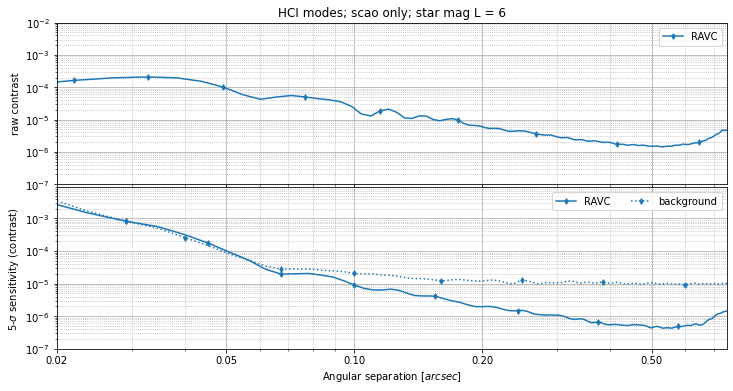

In [11]:
savename = 'contrast_curve.png'
xlabel = 'Angular separation $[arcsec]$'
ylabel_adi = '5-$\sigma$ sensitivity (contrast)'
ylabel_raw = 'raw contrast'
fig = plt.figure(figsize=(12, 6))
fig.subplots(2, 1, sharex=True)
fig.subplots_adjust(hspace=0.02)
axes = fig.axes
axes[0].set_ylim(1e-7, 1e-2)
axes[1].set_ylim(1e-7, 9e-3)
axes[1].set_xlabel(xlabel)
for j, (ax, ylabel) in enumerate(zip(axes, [ylabel_raw, ylabel_adi])):
    ax.set_ylabel(ylabel)
    ax.grid(True), ax.grid(which='minor', linestyle=':')
    ax.loglog()
    ax.xaxis.set_major_formatter(plt.ScalarFormatter())
    ax.set_xticks([0.02, 0.05, 0.1, 0.2, 0.5])
    ax.set_xlim(0.02, 0.75)
axes[0].plot(sep, raw, 'C0', label='RAVC', marker='d', markevery=0.12, markersize=4)
axes[0].legend()
axes[0].set_title('HCI modes; scao only; star mag L = 6')
axes[1].plot(sep1, adi1, 'C0', label='RAVC', marker='d', markevery=0.12, markersize=4)
axes[1].plot(sep2, adi2, ':C0', label='background', marker='d', markevery=0.12, markersize=4)
axes[1].legend(ncol=2, loc='upper right')
fig.savefig('%s/%s'%(conf['dir_output'], savename), dpi=300, transparent=True);